In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from src.fed_batch_pinn import PINN, numpy_to_tensor, train
from src.utils import get_data_and_feed
from typing import Optional, Union
from scipy.integrate import solve_ivp

import torch
import torch.nn as nn
from tqdm import tqdm 

pd.options.mode.chained_assignment = None

np.set_printoptions(precision=4)

%load_ext autoreload
%autoreload 2

In [22]:
def plot_feed(feeds):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(feeds['Time'], feeds['F'], width=feeds['Duration'], align='edge')
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Feed (mL/h)')
    ax.set_title('Feed vs Time')
    plt.show()
    
def plot_simulation(t=None, y=None, feeds: Optional[pd.DataFrame] = None, full_df: Optional[pd.DataFrame] = None, train_df: Optional[pd.DataFrame] = None, net_df: Optional[pd.DataFrame] = None, title: Optional[str] = None):
    fig, ax1 = plt.subplots(figsize=(10, 5))
    if t is not None and y is not None:
        ax1.plot(t, y[0], label='Biomass (ODE)', alpha=0.6)
        ax1.plot(t, y[1], label='Glucose (ODE)', alpha=0.6)
    
    if full_df is not None:
        ax1.scatter(full_df['RTime'], full_df['Glucose'], label='Glucose (EXP)', color='red', alpha=0.2)   
        ax1.scatter(full_df['RTime'], full_df['Biomass'], label='Biomass (EXP)', color='green', alpha=0.2)
    
    if train_df is not None:
        ax1.scatter(train_df['RTime'], train_df['Glucose'], label='Glucose (Train)', color='red', alpha=1)   
        ax1.scatter(train_df['RTime'], train_df['Biomass'], label='Biomass (Train)', color='green', alpha=1)
    
    if net_df is not None:
        ax1.scatter(net_df['RTime'], net_df['Glucose'], label='Glucose (Predicted)', marker='x', color='red', alpha=0.5)
        ax1.scatter(net_df['RTime'], net_df['Biomass'], label='Biomass (Predicted)', marker='x', color='green', alpha=0.5)

    plt.xlabel("Time (hours)")
    plt.ylabel("Concentration")
    plt.title(title)
    
    if feeds is not None:
        ax2 = ax1.twinx()
        ax2.bar(feeds['Time'], feeds['F'], width=feeds['Duration'], \
            align='edge', label='Feed', alpha=0.5, color=None, \
            edgecolor='black', linewidth=1, fill=False)
        ax2.set_ylabel('Feed Rate')

    
    handles1, labels1 = ax1.get_legend_handles_labels()
    if feeds is not None:
        handles2, labels2 = ax2.get_legend_handles_labels()
        handles = handles1 + handles2
        labels = labels1 + labels2
        ax2.legend(handles, labels, loc='upper left')
    else:
        ax1.legend(handles1, labels1, loc='upper left')

    plt.show()
 
def get_feed(feeds: pd.DataFrame, time: float) -> float:
    for _, row in feeds.iterrows():
        start_time = row["Time"]
        end_time = row["Time"] + row["Duration"]
        if start_time <= time < end_time:
            return row["F"] / 1000
    return 0

def simulate(df: pd.DataFrame, feeds: pd.DataFrame, mu_max, Ks, Yxs, plot: bool = True):
    mu_max = mu_max
    Ks = Ks
    Yxs = Yxs
    Sin = 1.43 * 200

    def system_ode(t, y):
        X, S, V = y
        mu = mu_max * S / (Ks + S)
        F = get_feed(feeds, t)
        dXdt = mu * X + F * X / V
        dSdt = - mu * X / Yxs + F * (Sin - S) / V
        dVdt = F
        return [dXdt, dSdt, dVdt]
    
    t_start, t_end = df['RTime'].min(), df['RTime'].max()
    t_span = (t_start, t_end)
    y0 = [df['Biomass'].iloc[0], df['Glucose'].iloc[0], df['V'].iloc[0]]

    t_eval = np.linspace(t_start, t_end, 10000)
    sol = solve_ivp(system_ode, t_span=t_span, \
        y0=y0, t_eval=t_eval)
    
    if plot:
        plot_simulation(sol.t, sol.y, feeds=feeds, full_df=df)

    for i in range(sol.y.shape[0]):
        sol.y[i][sol.y[i] < 0] = 0

    return sol

def get_predictions_df(net: nn.Module, df: pd.DataFrame):
    net_df = pd.DataFrame(columns=['RTime', 'Biomass', 'Glucose'])
    t_test = df['RTime'].values
    t_test = numpy_to_tensor(t_test)
    net_df["RTime"] = df["RTime"].values
    net_df["Biomass"] = net.forward(t_test).detach().cpu().numpy()[:, 0]
    net_df["Glucose"] = net.forward(t_test).detach().cpu().numpy()[:, 1]
    net_df["V"] = net.forward(t_test).detach().cpu().numpy()[:, 2]
    net_df.loc[net_df['Glucose'] < 0, 'Glucose'] = 0
    return net_df

In [23]:
FILENAME = '../data/data_processed.xlsx'
EXPERIMENT = 'BR01'

_df, feeds = get_data_and_feed(FILENAME, EXPERIMENT)

# Only FED-BATCH data
_df = _df[_df['Process'] == 'FB']
feeds = feeds[feeds['Induction']==0]

print(f'Dataset shape: {_df.shape}')

Dataset shape: (11, 8)


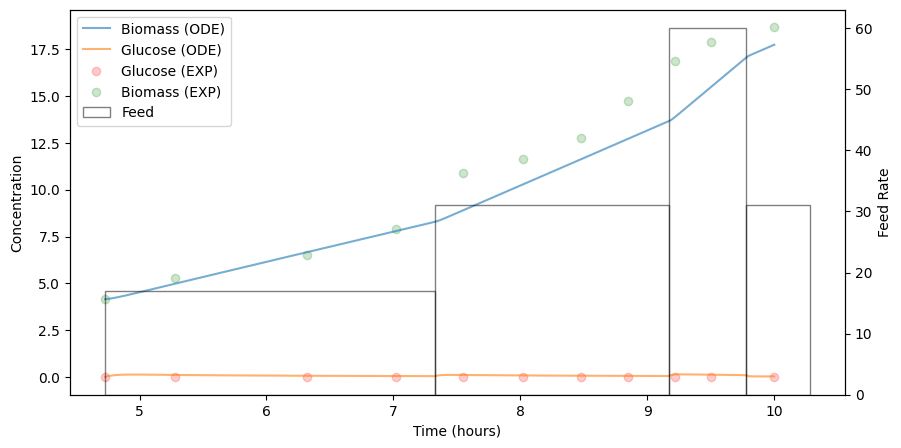

In [24]:
_ = simulate(_df, feeds, mu_max=0.870, Ks=0.214, Yxs=0.496)

Training with 2 data points


100%|██████████| 2500/2500 [00:27<00:00, 91.41it/s]


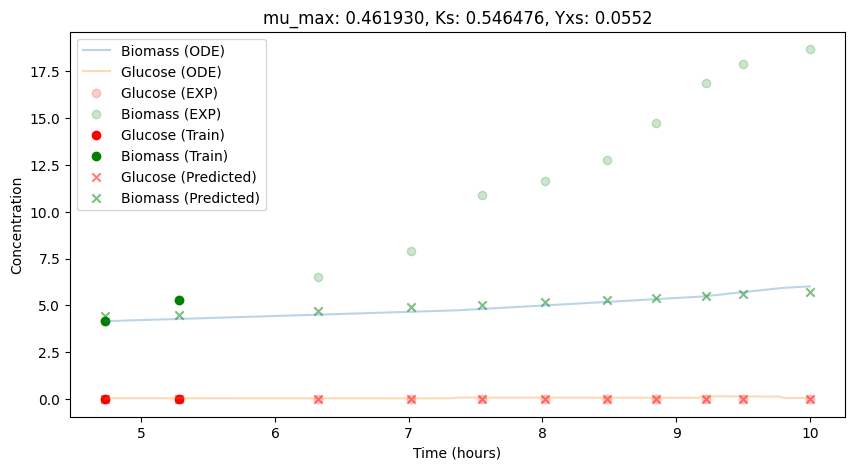

Training with 3 data points


100%|██████████| 2500/2500 [00:26<00:00, 93.59it/s]


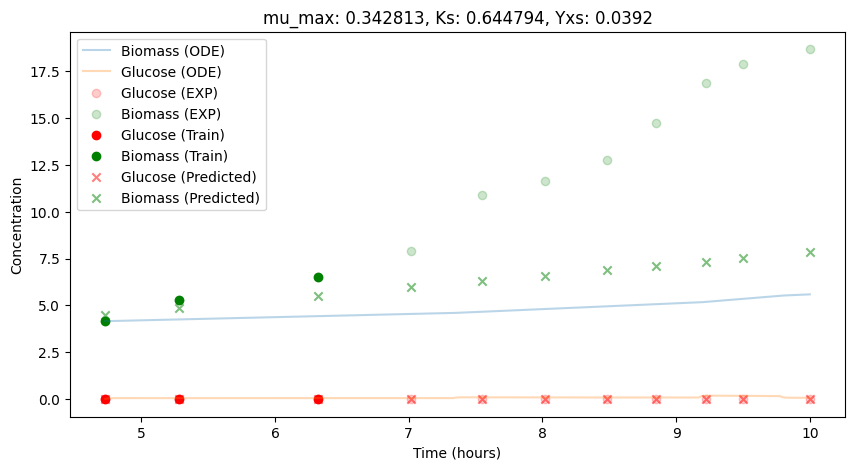

Training with 4 data points


100%|██████████| 2500/2500 [01:11<00:00, 35.07it/s]


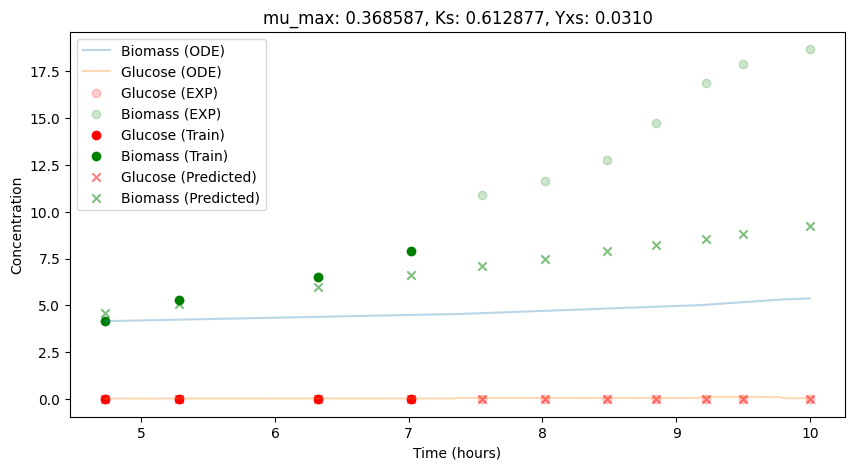

Training with 5 data points


100%|██████████| 2500/2500 [01:11<00:00, 34.96it/s]


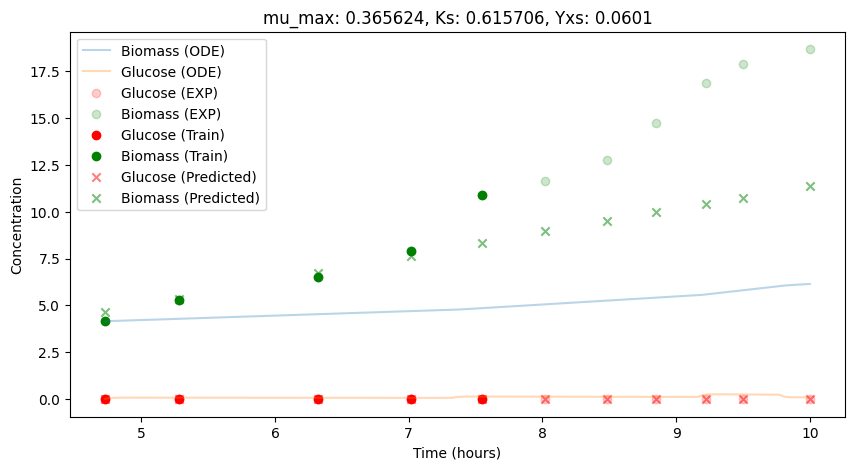

Training with 6 data points


100%|██████████| 2500/2500 [00:49<00:00, 50.50it/s]


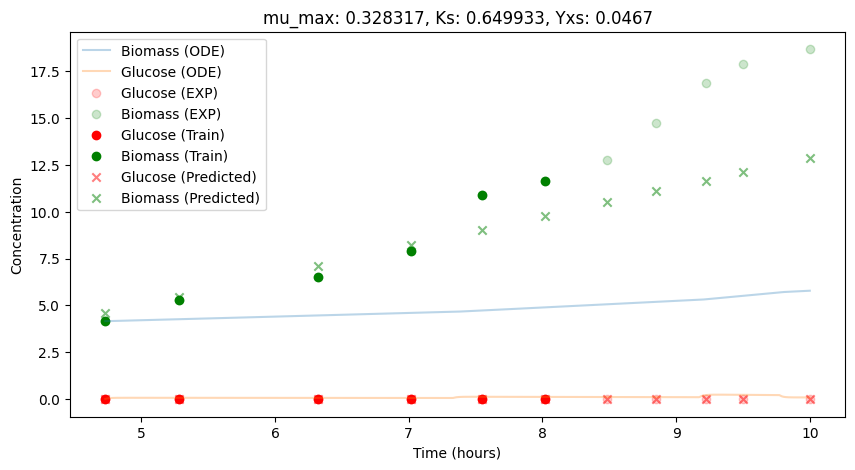

Training with 7 data points


100%|██████████| 2500/2500 [00:50<00:00, 49.48it/s]


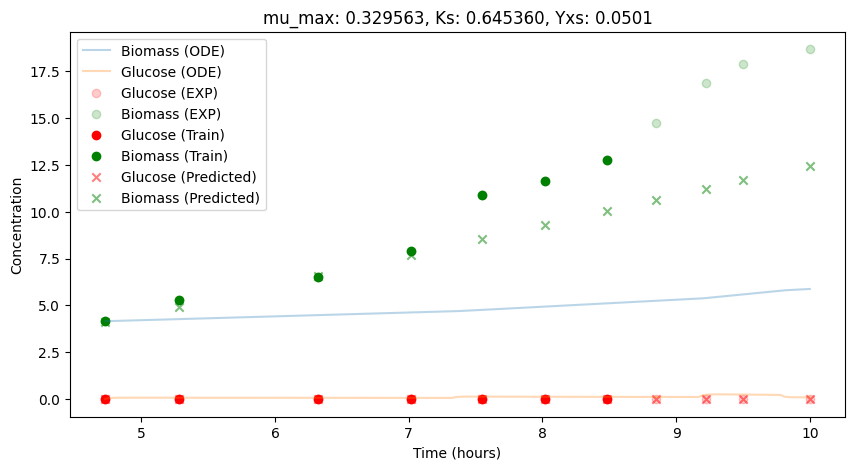

Training with 8 data points


100%|██████████| 2500/2500 [00:42<00:00, 58.66it/s]


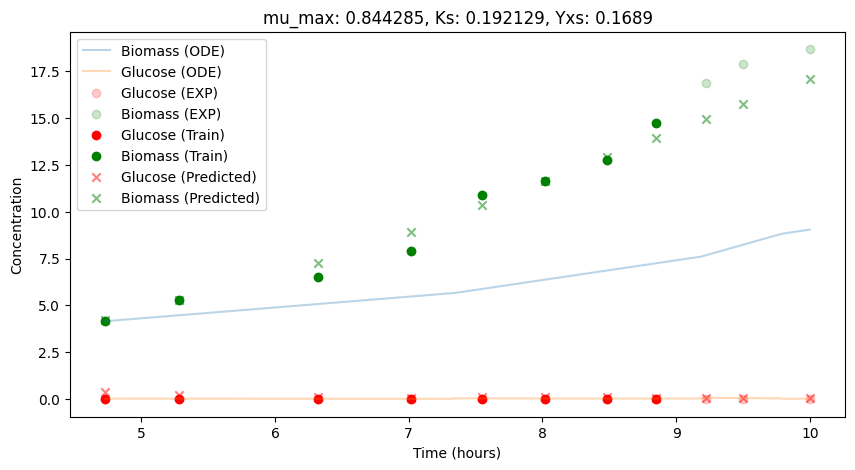

Training with 9 data points


100%|██████████| 2500/2500 [00:41<00:00, 60.11it/s]


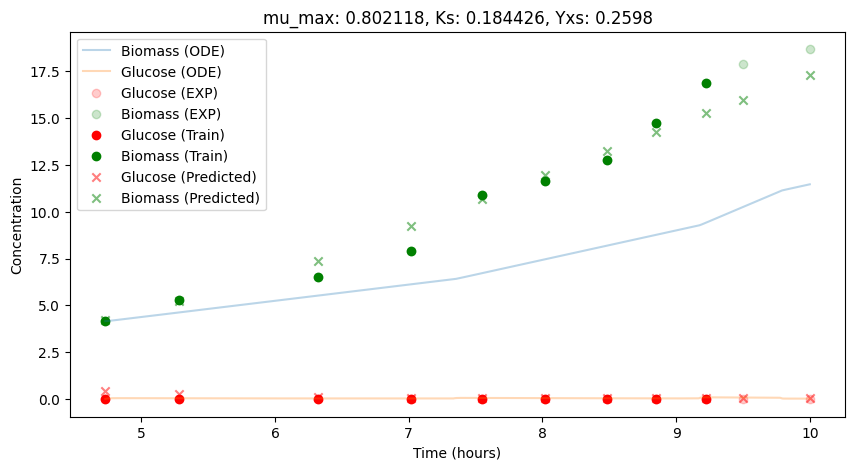

Training with 10 data points


100%|██████████| 2500/2500 [00:42<00:00, 59.00it/s]


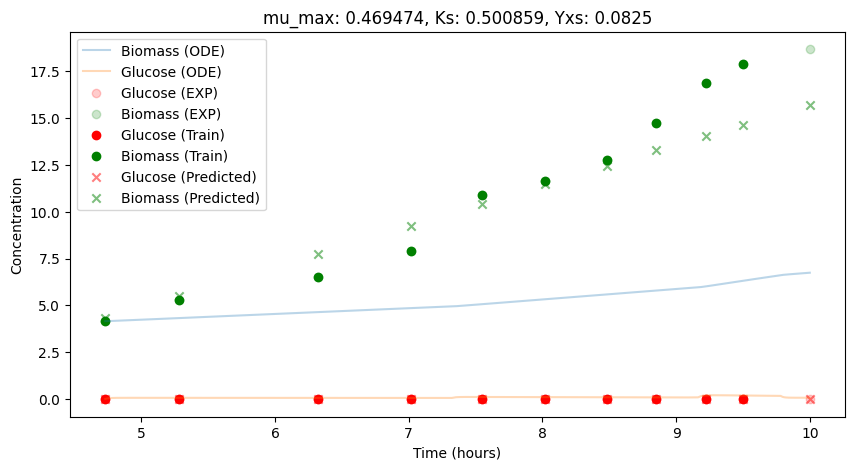

Training with 11 data points


100%|██████████| 2500/2500 [00:31<00:00, 78.48it/s]


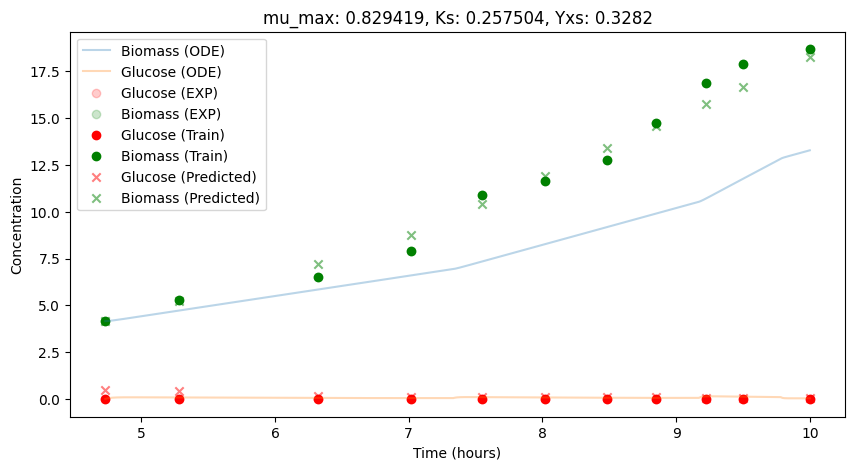

In [4]:
for i in range(2, len(_df)+1):
    
    print(f'Training with {i} data points')
    df = _df.iloc[:i]
    t_start, t_end = df['RTime'].min(), df['RTime'].max()

    t_train = numpy_to_tensor(df['RTime'].values)
    Biomass_train = numpy_to_tensor(df['Biomass'].values)
    Glucose_train = numpy_to_tensor(df['Glucose'].values)
    V_train = numpy_to_tensor(df['V'].values)
    u_train = torch.cat((Biomass_train, Glucose_train, V_train), 1)

    net = PINN(input_dim=1, output_dim=3, t_start=t_start, t_end=t_end)

    net = train(net, t_train, u_train, df, feeds, num_epochs=2500, verbose=False)

    net_df = get_predictions_df(net, _df)    

    sol = simulate(_df, feeds, net.mu_max.item(), net.K_s.item(), net.Y_xs.item(), plot=False)

    title = f"mu_max: {net.mu_max.item():4f}, Ks: {net.K_s.item():4f}, Yxs: {net.Y_xs.item():.4f}"
    plot_simulation(sol.t, sol.y, net_df=net_df, train_df=df, full_df=_df, title=title)